# Coulomb Stopping Power Tests

Module stoppingpower contains routines for numerical integration of stopping powers for incident charged particles Coulomb scattering off a $T=0$ Fermi sea of electrons.  No asumptions are made about the incident particle's mass or initial kinematics.   

In [1]:
%matplotlib inline

import time 

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15,20]

import stoppingpower as sp
reload(sp)

<module 'stoppingpower' from 'stoppingpower.pyc'>

### Carbon ion and pion tests

In [2]:
m_electron = 0.5 # MeV
Z_electron = -1.0 # charge
n_electron = 10**32 # cm^{-3}, electron number density

M_carbon = 10**4 # MeV
Z_carbon = 6.0

M_pion = 10**2 # Mev
Z_pion = 1.0

M_heavy = 10**7 # Mev
Z_heavy = 1.0

Initialize Fermi Sea properties, and construct stopping power functions.  This sets the energy unit to be MeV and the stopping power will be given in MeV/cm.

In [3]:
wd = sp.FermiSea_StoppingPower(m=m_electron, n0=n_electron, 
                               masstolength=sp.MeV_to_InvCM)
dedx_carbon_func = wd.get_coulomb_stopping_power(M_carbon, Z_carbon)
dedx_pion_func = wd.get_coulomb_stopping_power(M_pion, Z_pion)
dedx_heavy_func = wd.get_coulomb_stopping_power(M_heavy, Z_heavy)

Stopping power functions accept an (array of) incident kinetic energy and do a monte carlo integral over electron momentum, electron incident direction, and the com scattering angle.  

In [4]:
dedx_carbon_func(100.0, samples=1000)

array([[ 2026710.86026659],
       [  486493.35168764]])

In [5]:
timeit dedx_carbon_func([10.0**-2, 1.0, 100.0, 10**4, 10**6], samples=1000)

1 loop, best of 3: 921 ms per loop


Timing: 0.4 sec per 5000 samples, $\Rightarrow 10^{-4}$ sec per sample. 
Need at least $10^5$ samples for incident momentum percent-level accuracy - thats $10$ seconds per momentum point and about $10$ to $20$ minutes to construct one stopping power curve.  

In [6]:
ke = np.logspace(-5, 12, 50)  
    # incident momenta log-spaced between 10^{-5} and 10^{12} MeV
samples = 10**4
t0 = time.time()
dedx_carbon, dedx_carbon_error = dedx_carbon_func(ke, samples=samples)
dedx_pion, dedx_pion_error = dedx_pion_func(ke, samples=samples)
dedx_heavy, dedx_heavy_error = dedx_heavy_func(ke, samples=samples)
print "finished in {:0.2f} minutes".format((time.time() - t0)/60.0)

# np.savetxt("dedx_carbon.txt", np.concatenate(([ke], [dedx_carbon], [dedx_carbon_error])).T)
# np.savetxt("dedx_pion.txt", np.concatenate(([ke], [dedx_pion], [dedx_pion_error])).T)
# np.savetxt("dedx_heavy.txt", np.concatenate(([ke], [dedx_heavy], [dedx_heavy_error])).T)

finished in 4.57 minutes


stoppingpower can also construct an approximate function based on the limiting cases of relativistic or non-relativistic incident particles, assuming as well an incdient particle much heavier than the target electrons and that the target electrons are relativistic. approx_sp_piecewise is a piecewise approximation to the stopping power using these two limiting case.   

The non-relativistic limit takes the target to be essentially stationary, and is valid as long as the incident momentum is greater than the target fermit momentum.  Below this threshold, the target motion and Pauli blocking probhits any energy transfer.  This is Paul's esitmate, and gives $dE/dx \sim E^{1/2}$ where $E$ is the incident kinetic energy. (Note that this results involves a fixed but complicated integral over scattering and incident angles. I haven't done this integral, but rather set it's value by eye to match the numerical result. 

The relativistic result takes the electrons to be at rest, with an effective relativistic inertia $E_F$, and then demands that each energy transfer is still subject to Pauli blocking. This gives a stopping power that scales as the log of the incident kinetic energy (a la Jackson) which transitions to a polynomial behavior when the energy transfer drops below $E_F$. 

In [7]:
dedx_carbon_approx_func =  wd.approx_sp_piecewise(M_carbon, Z_carbon)
dedx_pion_approx_func =  wd.approx_sp_piecewise(M_pion, Z_pion)
dedx_heavy_approx_func = wd.approx_sp_piecewise(M_heavy, Z_heavy)

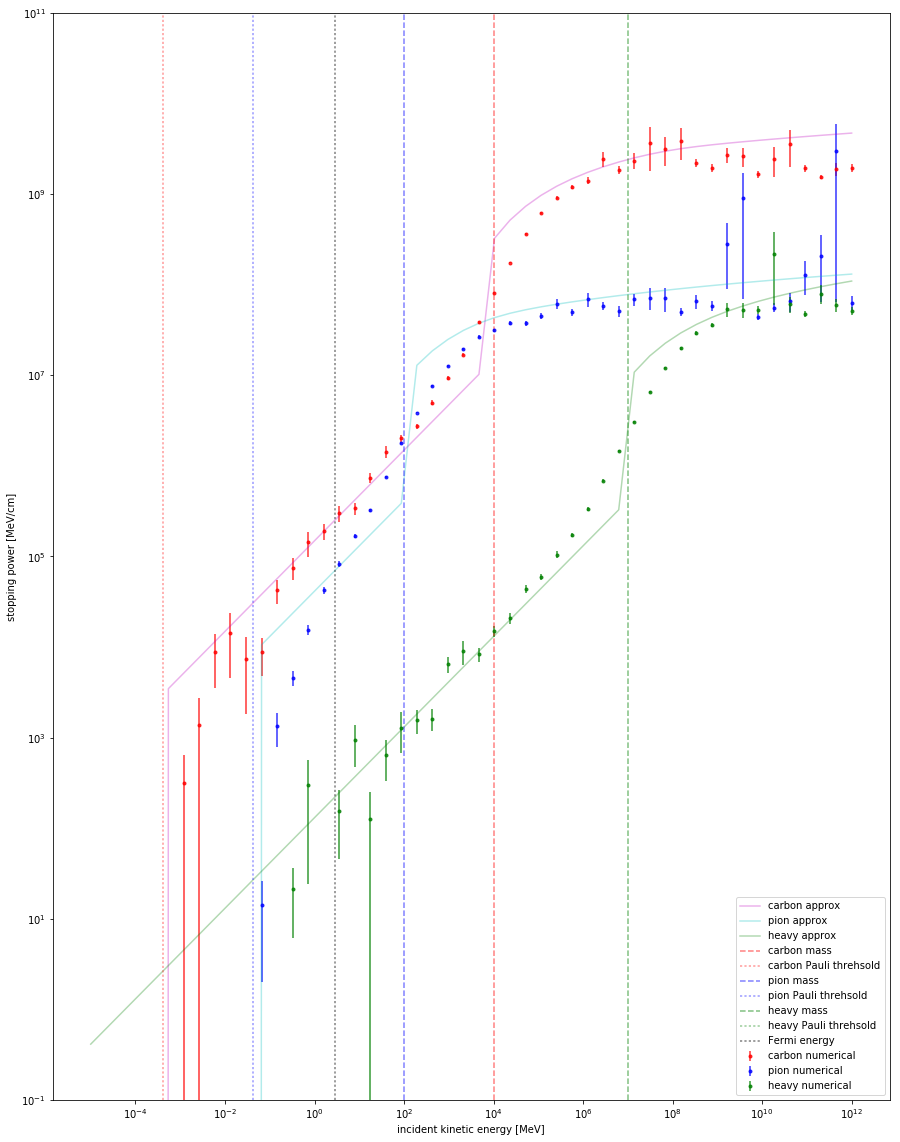

In [8]:
fig, ax = plt.subplots()

# numerical results 
ax.errorbar(ke, dedx_carbon, yerr=dedx_carbon_error, 
            alpha=0.8, marker='.', linestyle='', color='r', 
            label='carbon numerical')
ax.errorbar(ke, dedx_pion, yerr=dedx_pion_error, 
            alpha=0.8, marker='.', linestyle='', color='b', 
            label='pion numerical')
ax.errorbar(ke, dedx_heavy, yerr=dedx_heavy_error, 
            alpha=0.8, marker='.', linestyle='', color='g', 
            label='heavy numerical')

# limiting approximations
ax.plot(ke, dedx_carbon_approx_func(ke), alpha=0.3,
        marker='', linestyle='-', color='m', 
        label='carbon approx')
ax.plot(ke, dedx_pion_approx_func(ke), alpha=0.3,
        marker='', linestyle='-', color='c', 
        label='pion approx')
ax.plot(ke, dedx_heavy_approx_func(ke), alpha=0.3,
        marker='', linestyle='-', color='g', 
        label='heavy approx')

# energy scales 
ax.axvline(M_carbon, linestyle='--', color='r', alpha=0.5, 
           label="carbon mass")
ax.axvline(wd.kinetic_cutoff(M_carbon), 
           linestyle=':', color='r', alpha=0.4, 
           label="carbon Pauli threhsold")
ax.axvline(M_pion, linestyle='--', color='b', alpha=0.5, 
           label="pion mass")
ax.axvline(wd.kinetic_cutoff(M_pion), 
           linestyle=':', color='b', alpha=0.4, 
           label="pion Pauli threhsold")
ax.axvline(M_heavy, linestyle='--', color='g', alpha=0.5, 
           label="heavy mass")
ax.axvline(wd.kinetic_cutoff(M_heavy), 
           linestyle=':', color='g', alpha=0.4, 
           label="heavy Pauli threhsold")
ax.axvline(wd.Efermi, linestyle=':', color='k', alpha=0.5, 
           label="Fermi energy")

ax.set_xlabel("incident kinetic energy [MeV]")
ax.set_ylabel("stopping power [MeV/cm]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([10**-1, 10**11])
ax.legend(loc="best")

old plot:
    carbon levels off just above 10^10 and ion/heavy just below 10^9 
    

/home/rjanish/installs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide
/home/rjanish/installs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide
/home/rjanish/installs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in divide
/home/rjanish/installs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide
/home/rjanish/installs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in divide
/home/rjanish/installs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in divide
/home/rjanish/installs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in divide
/home/rjanish/installs/anac

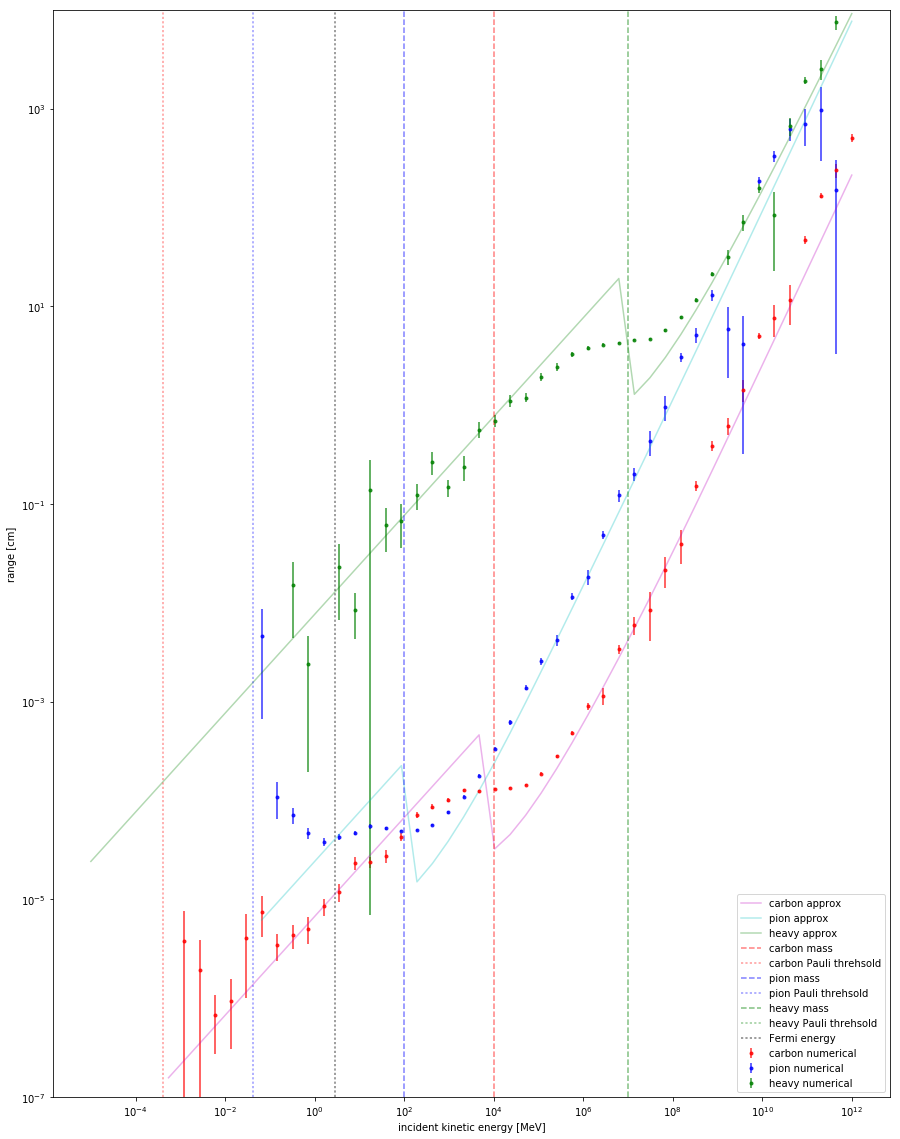

In [9]:
fig, ax = plt.subplots()

# numerical results 
ax.errorbar(ke, ke/dedx_carbon, 
            yerr=ke*dedx_carbon_error/(dedx_carbon**2), 
            alpha=0.8, marker='.', linestyle='', color='r', 
            label='carbon numerical')
ax.errorbar(ke, ke/dedx_pion, 
            yerr=ke*dedx_pion_error/(dedx_pion**2), 
            alpha=0.8, marker='.', linestyle='', color='b', 
            label='pion numerical')
ax.errorbar(ke, ke/dedx_heavy, 
            yerr=ke*dedx_heavy_error/(dedx_heavy**2), 
            alpha=0.8, marker='.', linestyle='', color='g', 
            label='heavy numerical')

# limiting approximations
ax.plot(ke, ke/dedx_carbon_approx_func(ke), alpha=0.3,
        marker='', linestyle='-', color='m', 
        label='carbon approx')
ax.plot(ke, ke/dedx_pion_approx_func(ke), alpha=0.3,
        marker='', linestyle='-', color='c', 
        label='pion approx')
ax.plot(ke, ke/dedx_heavy_approx_func(ke), alpha=0.3,
        marker='', linestyle='-', color='g', 
        label='heavy approx')

# energy scales 
ax.axvline(M_carbon, linestyle='--', color='r', alpha=0.5, 
           label="carbon mass")
ax.axvline(wd.kinetic_cutoff(M_carbon), 
           linestyle=':', color='r', alpha=0.4, 
           label="carbon Pauli threhsold")
ax.axvline(M_pion, linestyle='--', color='b', alpha=0.5, 
           label="pion mass")
ax.axvline(wd.kinetic_cutoff(M_pion), 
           linestyle=':', color='b', alpha=0.4, 
           label="pion Pauli threhsold")
ax.axvline(M_heavy, linestyle='--', color='g', alpha=0.5, 
           label="heavy mass")
ax.axvline(wd.kinetic_cutoff(M_heavy), 
           linestyle=':', color='g', alpha=0.4, 
           label="heavy Pauli threhsold")
ax.axvline(wd.Efermi, linestyle=':', color='k', alpha=0.5, 
           label="Fermi energy")

ax.set_xlabel("incident kinetic energy [MeV]")
ax.set_ylabel("range [cm]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([10**-7, 10**4])
ax.legend(loc="best")

For the $10$ TeV particle, the non-relativistic $E^{1/2}$ scaling is clear, though for both the pion and carbon the kinetic-pauli cutoff kicks in before a non-relativistic region develops.  

Again the $10$ TeV cases matches very well the expected log behavior at high energies, and in the other cases the numerical results is a bit below this.  This is probably due to the kinetic-pauli cutoff turning on and/or recoil effects which were ignored in these approximations. 

### Incident electrons

Note that this is ignoring identical particle effects. 

In [37]:
dedx_electron_func = wd.get_coulomb_stopping_power(m_electron, Z_electron)
dedx_electron_approx_func =  wd.approx_sp_piecewise(m_electron, Z_electron)
ke = np.logspace(-1, 12, 50)  

In [40]:
samples = 5*10**4
t0 = time.time()
dedx_electron, dedx_electron_error = dedx_electron_func(ke, 
                                                        samples=samples)
print "finished in {:0.2f} minutes".format((time.time() - t0)/60.0)

finished in 2.29 minutes


/home/rjanish/installs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in divide
/home/rjanish/installs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


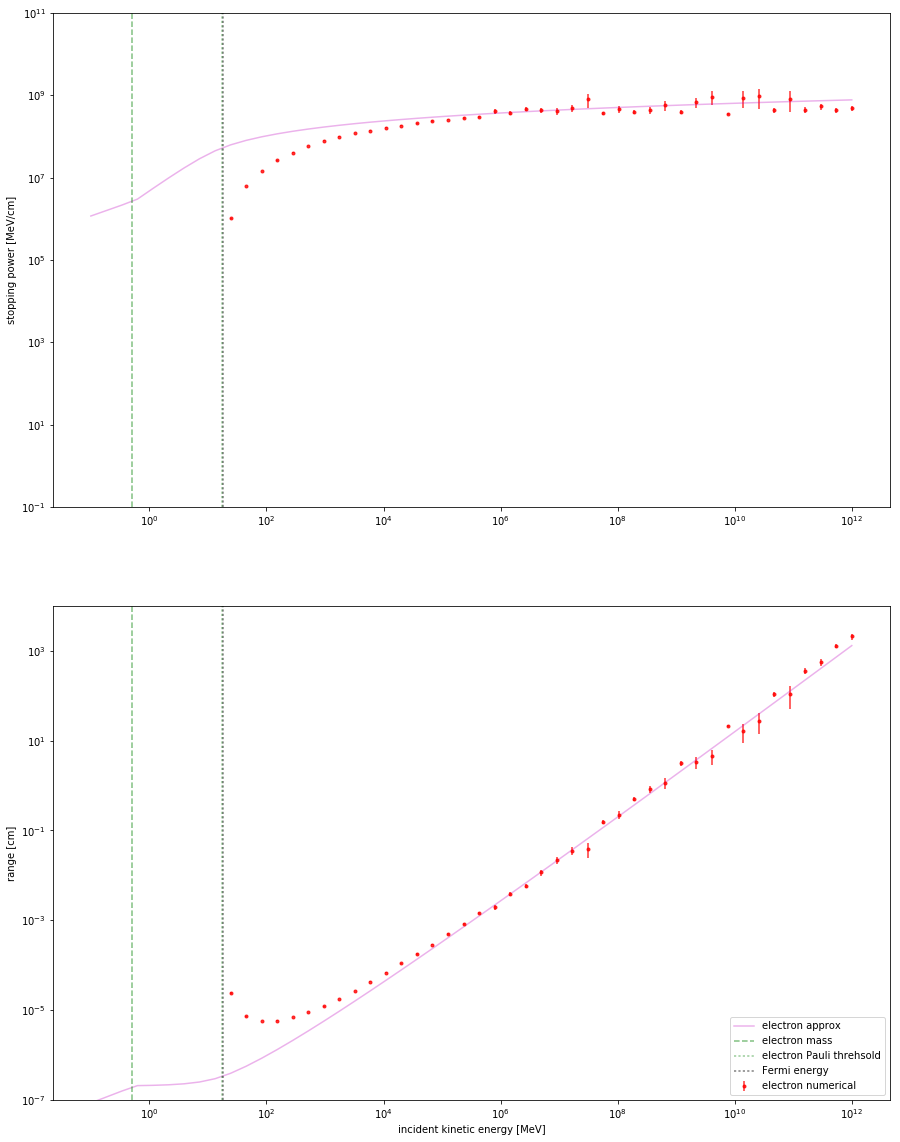

In [39]:
fig, axes = plt.subplots(2, 1)
ax_sp, ax_lambda = axes

# numerical results 
ax_sp.errorbar(ke, dedx_electron, yerr=dedx_electron_error, 
            alpha=0.8, marker='.', linestyle='', color='r', 
            label='electron numerical')
ax_lambda.errorbar(ke, ke/dedx_electron, 
                   yerr=ke*dedx_electron_error/(dedx_electron**2), 
                   alpha=0.8, marker='.', linestyle='', color='r', 
                   label='electron numerical')

# limiting approximations
ax_sp.plot(ke, dedx_electron_approx_func(ke), 
           alpha=0.3, marker='', linestyle='-', color='m', 
           label='electron approx')
ax_lambda.plot(ke, ke/dedx_electron_approx_func(ke),
               alpha=0.3, marker='', linestyle='-', color='m', 
               label='electron approx')

# energy scales 
for ax in [ax_sp, ax_lambda]:
    ax.axvline(m_electron, linestyle='--', color='g', alpha=0.5, 
               label="electron mass")
    ax.axvline(wd.kinetic_cutoff(m_electron), 
               linestyle=':', color='g', alpha=0.4, 
               label="electron Pauli threhsold")
    ax.axvline(wd.Efermi, linestyle=':', color='k', alpha=0.5, 
               label="Fermi energy")
# labels
ax_sp.set_ylabel("stopping power [MeV/cm]")
ax_sp.set_xscale("log")
ax_sp.set_yscale("log")
ax_sp.set_ylim([10**-1, 10**11])

ax_lambda.set_ylabel("range [cm]")
ax_lambda.set_xscale("log")
ax_lambda.set_yscale("log")
ax_lambda.set_ylim([10**-7, 10**4])

ax_lambda.set_xlabel("incident kinetic energy [MeV]")
ax_lambda.legend(loc="best")

### Plasma Screening 

In [21]:
dedx_pion_func = wd.get_coulomb_stopping_power(M_pion, Z_pion)
dedx_heavy_func = wd.get_coulomb_stopping_power(M_heavy, Z_heavy)

dedx_pionscreened_func = wd.get_thomasfermicoulomb_stopping_power(M_pion, Z_pion)
dedx_heavyscreened_func = wd.get_thomasfermicoulomb_stopping_power(M_heavy, Z_heavy)

ke = np.logspace(-6, 12, 50)  # 100 samples log-spaced between 10^-4 and 10^9
samples = 10**5
t0 = time.time()
dedx_pion, dedx_pion_error = dedx_pion_func(ke, samples=samples)
dedx_heavy, dedx_heavy_error = dedx_heavy_func(ke, samples=samples)
dedx_pionscreened, dedx_pionscreened_error = dedx_pionscreened_func(ke, samples=samples)
dedx_heavyscreened, dedx_heavyscreened_error = dedx_heavyscreened_func(ke, samples=samples)
print "finished in {:0.2f} minutes".format((time.time() - t0)/60.0)

finished in 14.62 minutes


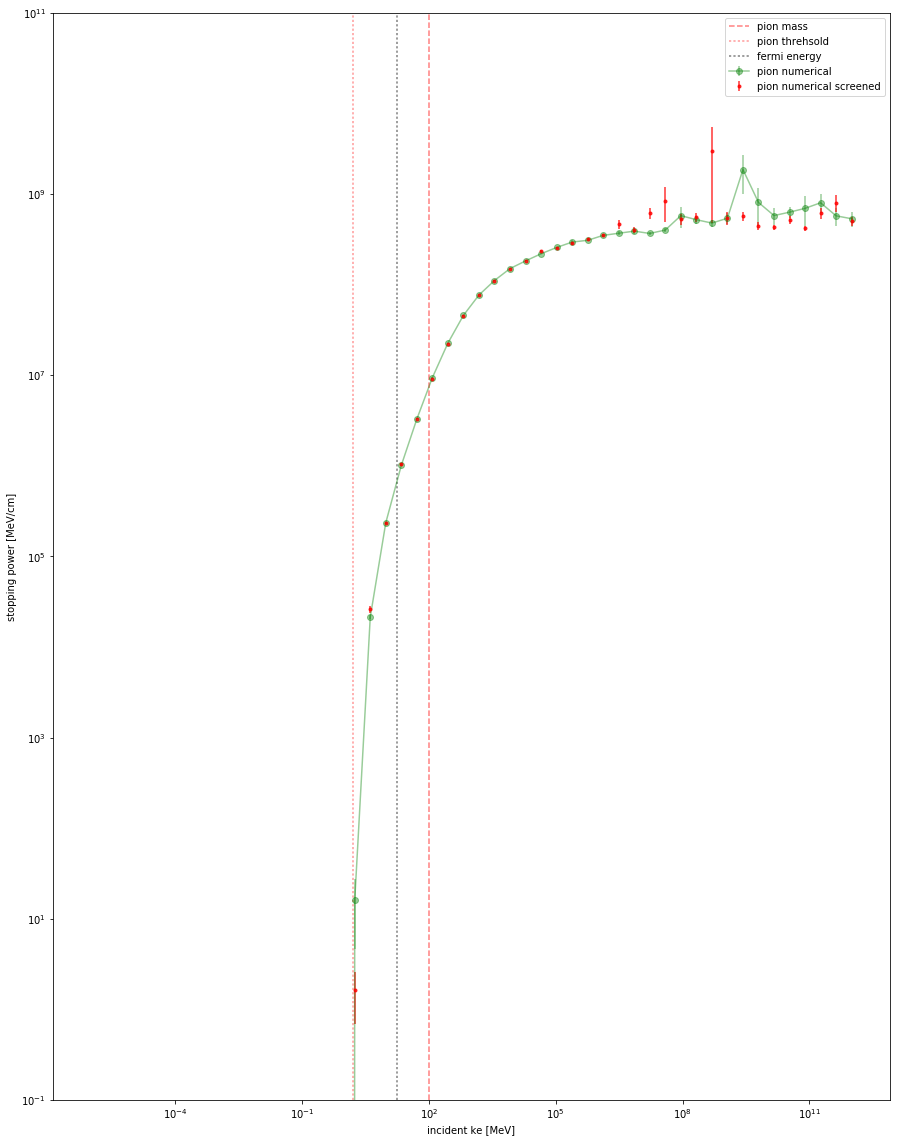

In [22]:
fig, ax = plt.subplots()

# numerical results 
ax.errorbar(ke, dedx_pion, yerr=dedx_pion_error, alpha=0.4,
            marker='o', linestyle='-', color='g', label='pion numerical')
ax.errorbar(ke, dedx_pionscreened, yerr=dedx_pionscreened_error, alpha=0.8,
            marker='.', linestyle='', color='r', label='pion numerical screened')
# energy scales 
ax.axvline(M_pion, linestyle='--', color='r', alpha=0.5, label="pion mass")
ax.axvline(wd.kinetic_cutoff(M_pion), linestyle=':', color='r', alpha=0.4, label="pion threhsold")
ax.axvline(wd.Efermi, linestyle=':', color='k', alpha=0.5, label="fermi energy")

ax.set_xlabel("incident ke [MeV]")
ax.set_ylabel("stopping power [MeV/cm]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([10**-1, 10**11])
ax.legend(loc="best")

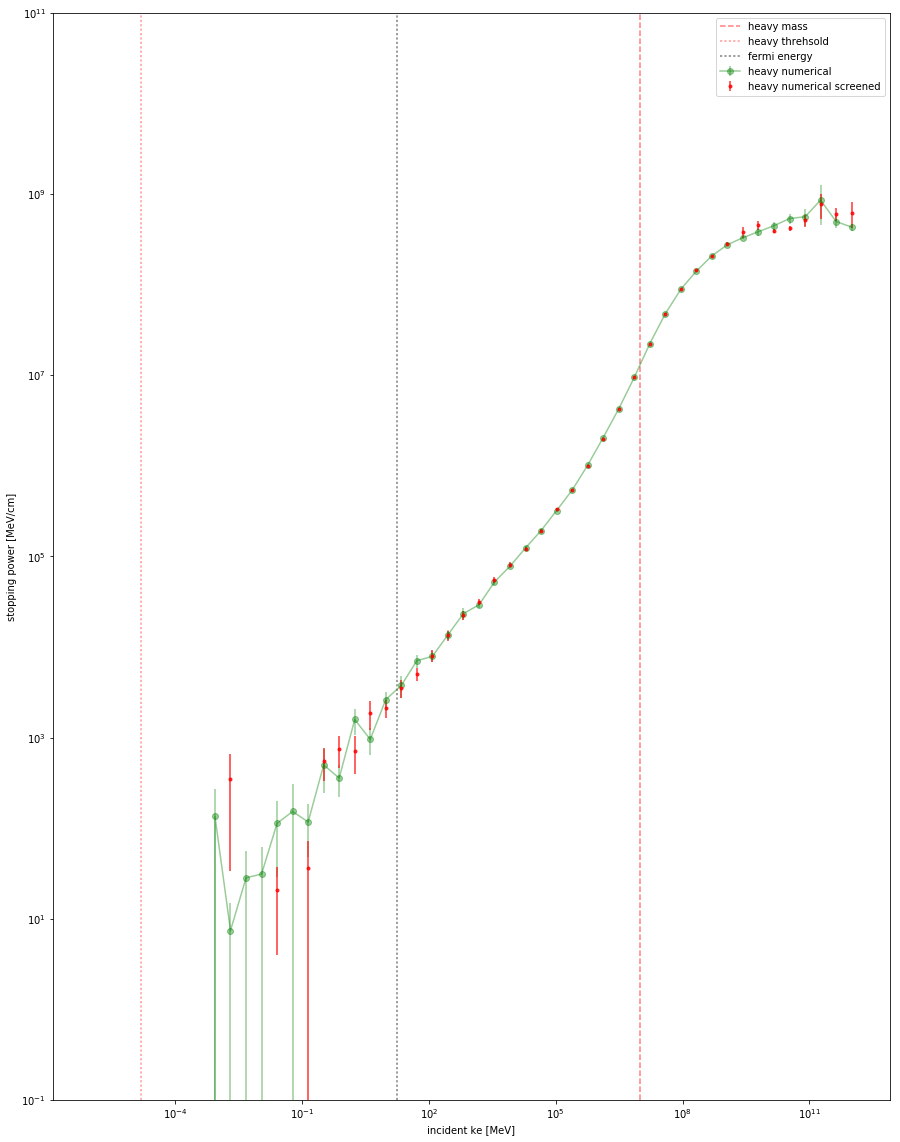

In [23]:
fig, ax = plt.subplots()

# numerical results 
ax.errorbar(ke, dedx_heavy, yerr=dedx_heavy_error, alpha=0.4,
            marker='o', linestyle='-', color='g', label='heavy numerical')
ax.errorbar(ke, dedx_heavyscreened, yerr=dedx_heavyscreened_error, alpha=0.8,
            marker='.', linestyle='', color='r', label='heavy numerical screened')
# energy scales 
ax.axvline(M_heavy, linestyle='--', color='r', alpha=0.5, label="heavy mass")
ax.axvline(wd.kinetic_cutoff(M_heavy), linestyle=':', color='r', alpha=0.4, label="heavy threhsold")
ax.axvline(wd.Efermi, linestyle=':', color='k', alpha=0.5, label="fermi energy")

ax.set_xlabel("incident ke [MeV]")
ax.set_ylabel("stopping power [MeV/cm]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([10**-1, 10**11])
ax.legend(loc="best")

### COM Azimuthal Integration 

In [15]:
ke = np.logspace(-5, 13, 30)  
    # incident momenta log-spaced between 10^{-5} and 10^{12} MeV
samples = 10**5

dedx_heavy_func = wd.get_coulomb_stopping_power(M_heavy, Z_heavy,
                                                azi=False)
dedx_heavy_azifunc = wd.get_coulomb_stopping_power(M_heavy, Z_heavy,
                                                   azi=True)
dedx_pion_func = wd.get_coulomb_stopping_power(M_pion, Z_pion,
                                                azi=False)
dedx_pion_azifunc = wd.get_coulomb_stopping_power(M_pion, Z_pion,
                                                   azi=True)

t00 = time.time()
dedx_heavy, dedx_heavy_error = dedx_heavy_func(ke, samples=samples)
print "finished in {:0.2f} minutes".format((time.time() - t00)/60.0)
t0 = time.time()
dedxazi_heavy, dedxazi_heavy_error = dedx_heavy_azifunc(ke, samples=samples)
print "finished in {:0.2f} minutes".format((time.time() - t0)/60.0)
t0 = time.time()
dedx_pion, dedx_pion_error = dedx_pion_func(ke, samples=samples)
print "finished in {:0.2f} minutes".format((time.time() - t0)/60.0)
t0 = time.time()
dedxazi_pion, dedxazi_pion_error = dedx_pion_azifunc(ke, samples=samples)
print "finished in {:0.2f} minutes".format((time.time() - t0)/60.0)
print "total       {:0.2f} minutes".format((time.time() - t00)/60.0)

finished in 4.56 minutes
finished in 4.66 minutes
finished in 4.95 minutes
finished in 5.03 minutes
total       19.19 minutes


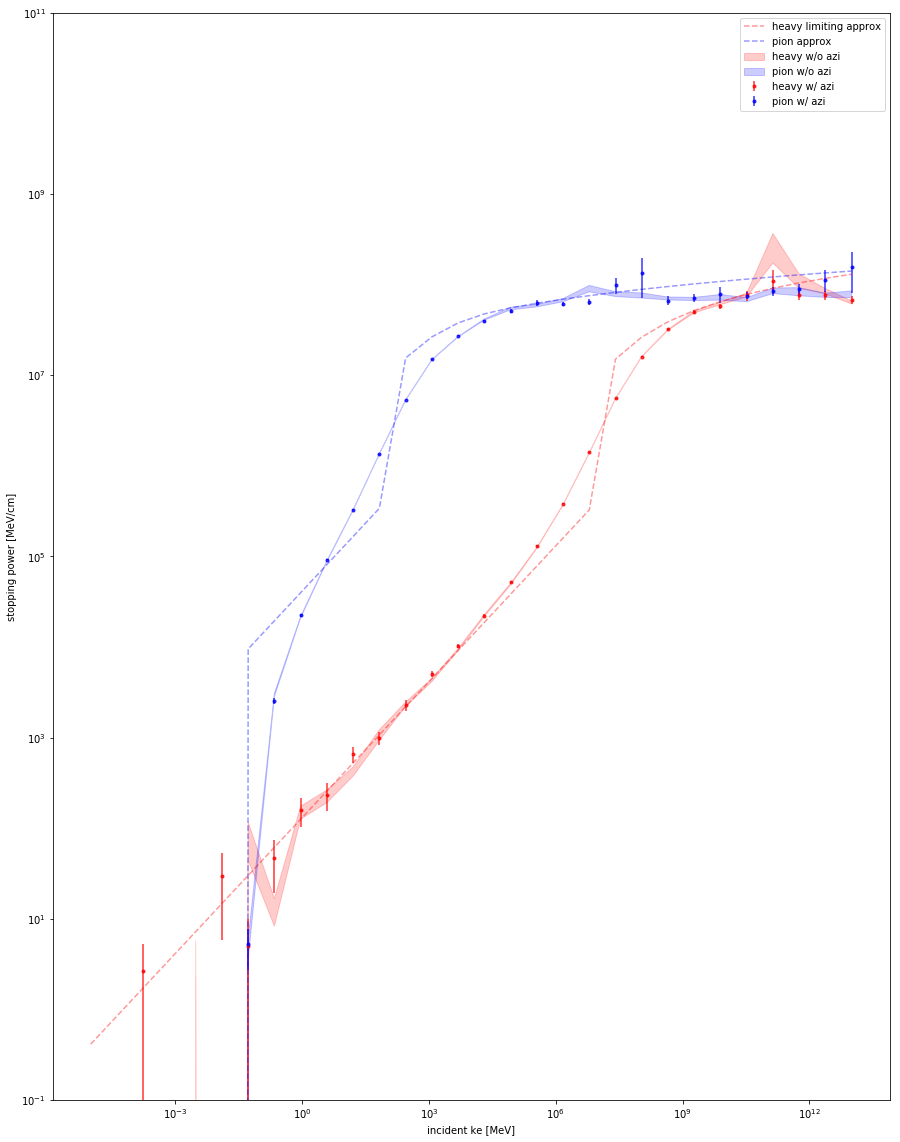

In [16]:
fig, ax = plt.subplots()

# stopping powers 
ax.fill_between(ke, dedx_heavy - 0.5*dedx_heavy_error, dedx_heavy + 0.5*dedx_heavy_error,
            alpha=0.2, color='r',
            label='heavy w/o azi')
ax.plot(ke, wd.approx_sp_piecewise(M_heavy, Z_heavy)(ke), 
           alpha=0.4, marker='', linestyle='--', color='r', 
           label='heavy limiting approx')
ax.errorbar(ke, dedxazi_heavy, yerr=dedxazi_heavy_error,
            alpha=0.8, marker='.', linestyle='', color='r',
            label='heavy w/ azi')

ax.fill_between(ke, dedx_pion - 0.5*dedx_pion_error, dedx_pion + 0.5*dedx_pion_error,
            alpha=0.2, color='b',
            label='pion w/o azi')
ax.plot(ke, wd.approx_sp_piecewise(M_pion, Z_pion)(ke), 
           alpha=0.4, marker='', linestyle='--', color='b', 
           label='pion approx')
ax.errorbar(ke, dedxazi_pion, yerr=dedxazi_pion_error,
            alpha=0.8, marker='.', linestyle='', color='b',
            label='pion w/ azi')

ax.set_xlabel("incident ke [MeV]")
ax.set_ylabel("stopping power [MeV/cm]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([10**-1, 10**11])
ax.legend(loc="best")